# Checkup: External balances in USDbn

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

Alternative: C:\ProgramData\Anaconda3\lib\site-packages\qstools\__init__.py win32


In [2]:
from_DB = True
path_to_feather = "..//data//feathers//"  # 

cids = ['AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'CNY', 'COP', 'EUR', 'GBP', 'HUF', 'IDR', 'INR', 'JPY', 
        'KRW', 'MYR', 'MXN', 'NOK', 'NZD', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SEK', 'SGD', 'THB', 
        'TRY', 'TWD', 'USD', 'ZAR']
cats = ['MTBUSDBN', 'CABUSDBN', 'NFDIUSDBN']

if from_DB:
    dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                              password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
    dfm = dbi.get_series_values(category=cats, cross_section=cids, frequency="m")  # import grade 1 vintages
    dfm.to_feather(f'{path_to_feather}dfm_xbs.tr')
else:
    dfm = pd.read_feather(f'{path_to_feather}dfm_xbs.tr')

In [8]:
dfm['ticker'] = dfm['cross_section'] + '_' + dfm['category_code'] + '_' + dfm['adjustment']  # add ticker column

In [9]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465744 entries, 0 to 5465743
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cross_section     object 
 1   category_code     object 
 2   adjustment        object 
 3   transformation    object 
 4   release_date      object 
 5   observation_date  object 
 6   value             float64
 7   grading           object 
 8   ticker            object 
dtypes: float64(1), object(8)
memory usage: 375.3+ MB


## Data availability

In [10]:
def countmap(cat, start_year, figsize=(12, 12), trueVin = False):
    dfx = dfm[dfm['category_code']==cat]
    if trueVin:
        dfx = dfx[dfx['grading'].isin(['1', '1.0', '2.2'])]
    xids = np.sort(dfx['cross_section'].unique())
    dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
    dfx = dfx[dfx.year >= start_year]

    dfxx = pd.DataFrame(columns=dfx.columns)
    for cid in xids:
        dfc = dfx.query('cross_section == @cid').reset_index(drop=True)
        releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
        dfcx = dfc[dfc['release_date'].isin(releases)]
        dfxx = dfxx.append(dfcx)

    count_matrix = pd.crosstab(dfxx["year"], dfxx["cross_section"])  # per default crosstab counts rows
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(count_matrix, annot=True, fmt="d",
                    cmap="YlGnBu", cbar=False, linewidths=.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(cat + ': Vintage lengths for last (available) release in year ', y = 1.1, fontsize=14)

### Availability of merchandise trade balances

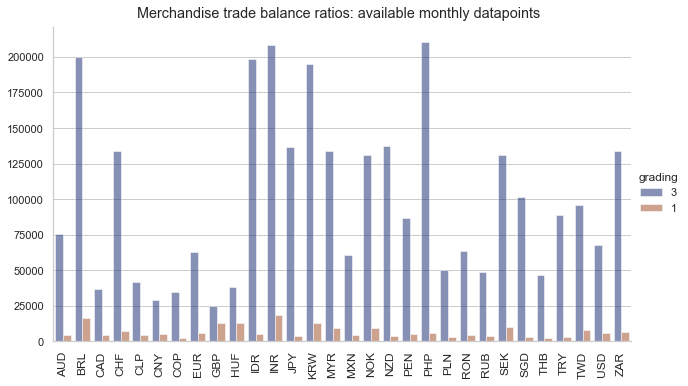

In [11]:
sns.set_theme(style='whitegrid')
g = sns.catplot(data=dfm[dfm['category_code']=='MTBUSDBN'], kind='count', order=cids, 
                x='cross_section', palette='dark', aspect=1.8, alpha=0.5, hue='grading')
g.set_xticklabels(rotation=90, size=12)
g.fig.suptitle('Merchandise trade balance ratios: available monthly datapoints', y=1.02)
plt.xlabel('')
plt.ylabel('')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

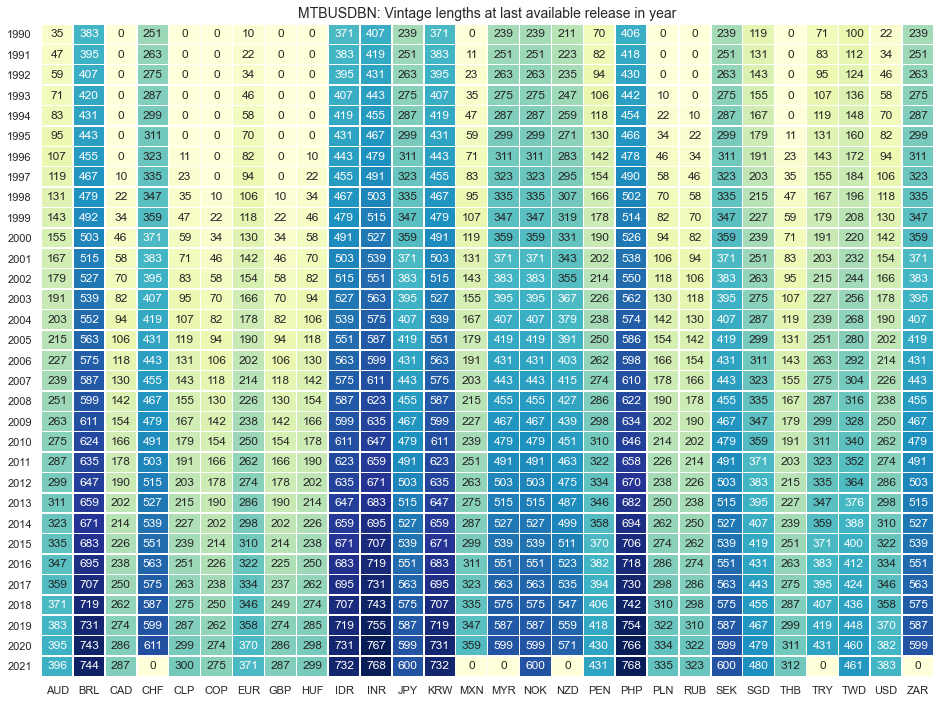

In [22]:
countmap('MTBUSDBN', 1990, (16, 12))
plt.show

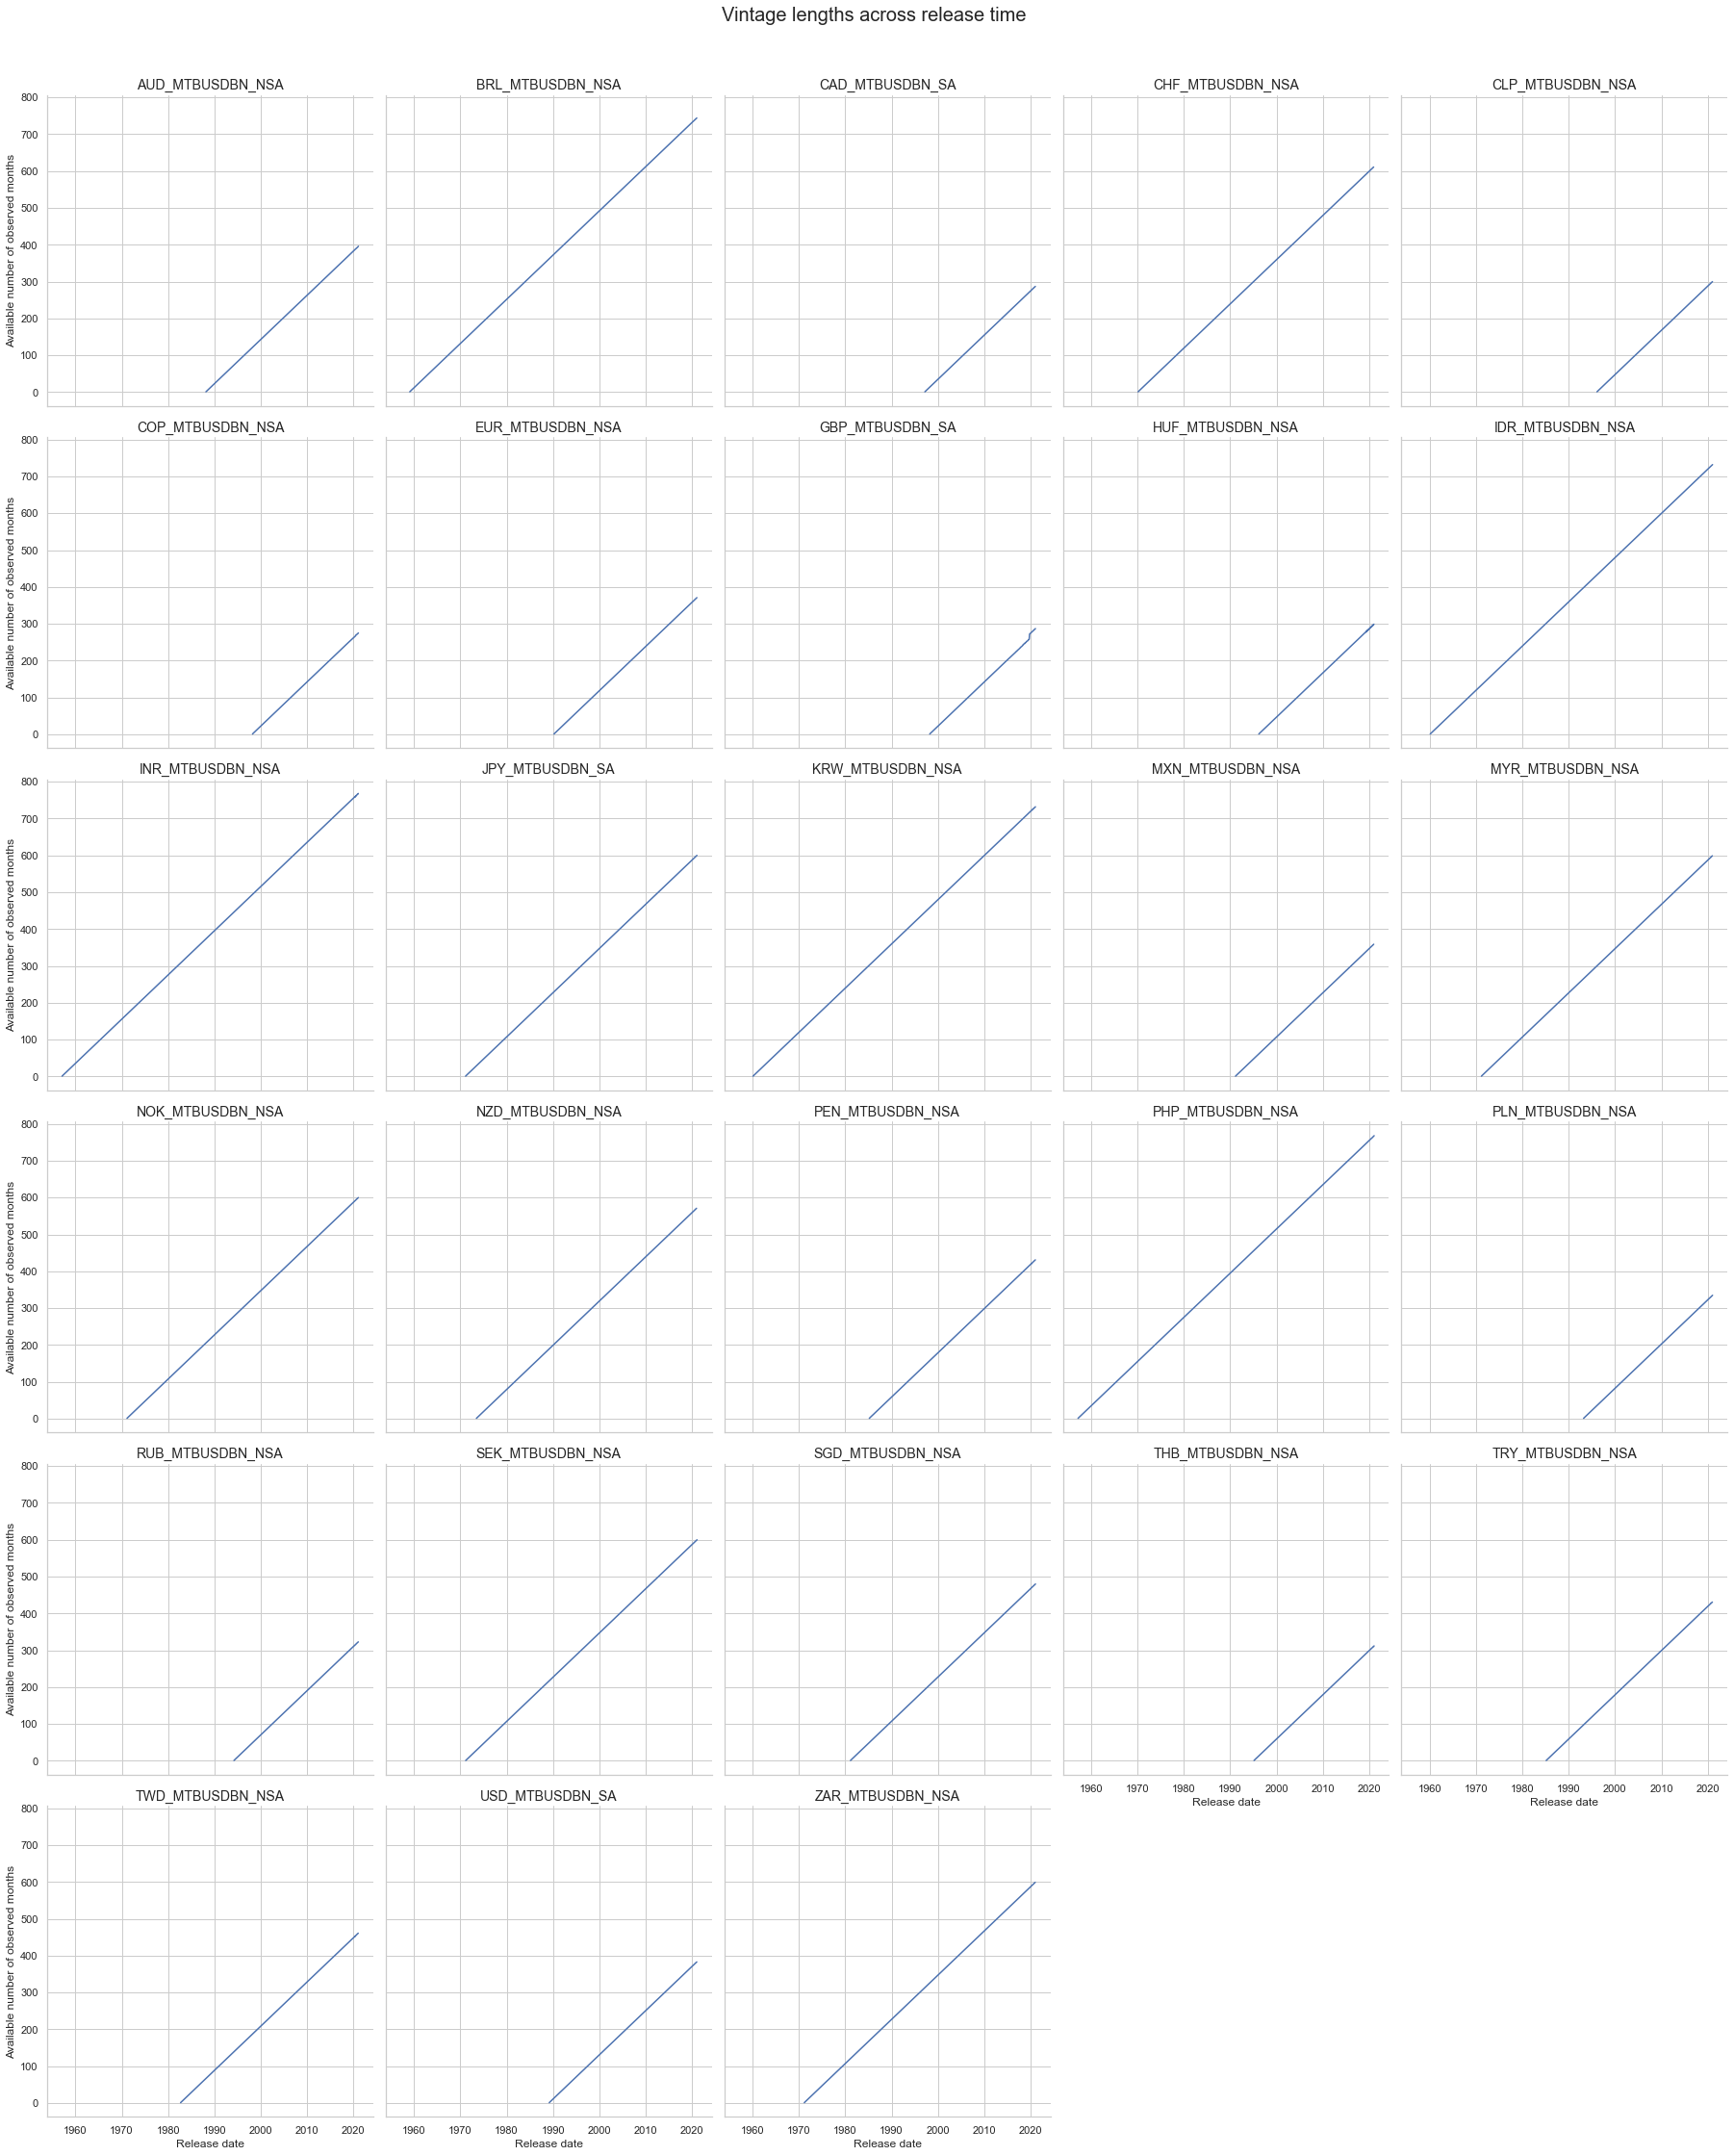

In [23]:
dfm_x = dfm.query('category_code == "MTBUSDBN"')
dfm_x = dfm_x.loc[:, ['ticker', 'release_date', 'observation_date']].groupby(['ticker', 'release_date']).agg('count')
dfm_x.reset_index(inplace=True)
f = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='ticker', col_wrap=5)
(f.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths across release time', y = 1.03, fontsize=20))
plt.show()

In [39]:
dfm_c = dfm.query('category_code == "MTBUSDBN"')
tiks = np.sort(dfm_c['ticker'].unique())
for tik in tiks:
    qs.misc.Vintages.vintages_check(dfm_c, tik)

The vintages of AUD_MTBUSDBN_NSA display no irregularities.
The vintages of BRL_MTBUSDBN_NSA display no irregularities.
The vintages of CAD_MTBUSDBN_SA display no irregularities.
The vintages of CHF_MTBUSDBN_NSA display no irregularities.
The vintages of CLP_MTBUSDBN_NSA display no irregularities.
The vintages of COP_MTBUSDBN_NSA display no irregularities.
The vintages of EUR_MTBUSDBN_NSA display no irregularities.
The vintages of GBP_MTBUSDBN_SA display no irregularities.
The vintages of HUF_MTBUSDBN_NSA display no irregularities.
The vintages of IDR_MTBUSDBN_NSA display no irregularities.
The vintages of INR_MTBUSDBN_NSA display no irregularities.
The vintages of JPY_MTBUSDBN_SA display no irregularities.
The vintages of KRW_MTBUSDBN_NSA display no irregularities.
The vintages of MXN_MTBUSDBN_NSA display no irregularities.
The vintages of MYR_MTBUSDBN_NSA display no irregularities.
The vintages of NOK_MTBUSDBN_NSA display no irregularities.
The vintages of NZD_MTBUSDBN_NSA display no

### Availability of current account balance

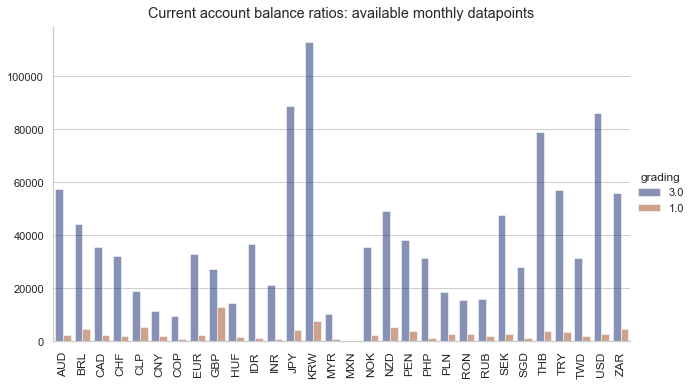

In [43]:
sns.set_theme(style='whitegrid')
g = sns.catplot(data=dfm[dfm['category_code']=='CABUSDBN'], kind='count', order=cids, hue='grading', 
                x='cross_section', palette='dark', aspect=1.8, alpha=0.5)
g.set_xticklabels(rotation=90, size=12)
g.fig.suptitle('Current account balance ratios: available monthly datapoints', y=1.02)
plt.xlabel('')
plt.ylabel('')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

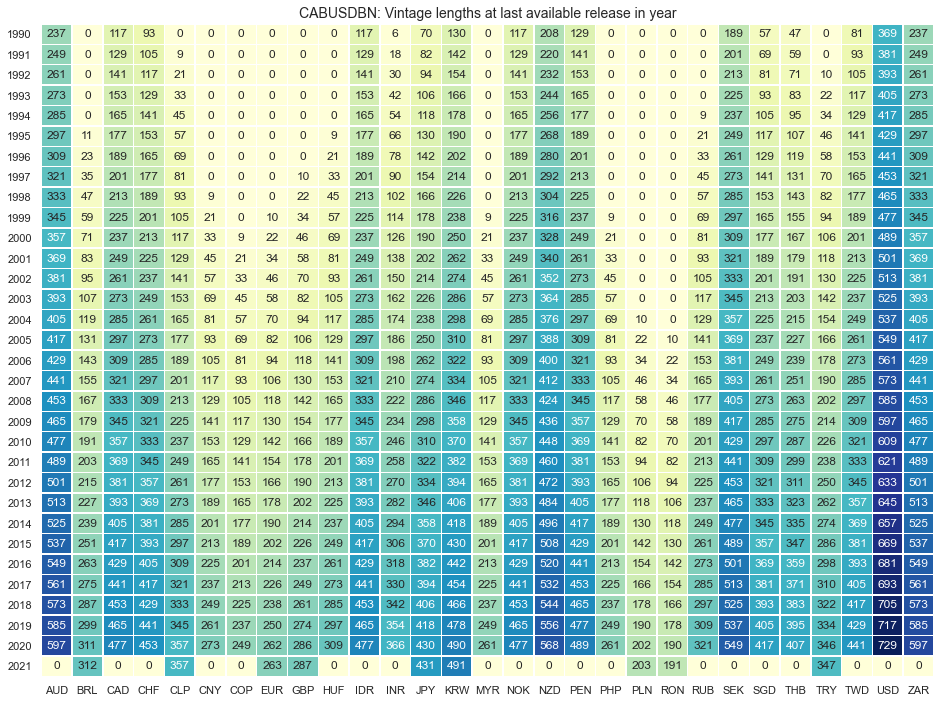

In [44]:
countmap('CABUSDBN', 1990, (16, 12))
plt.show

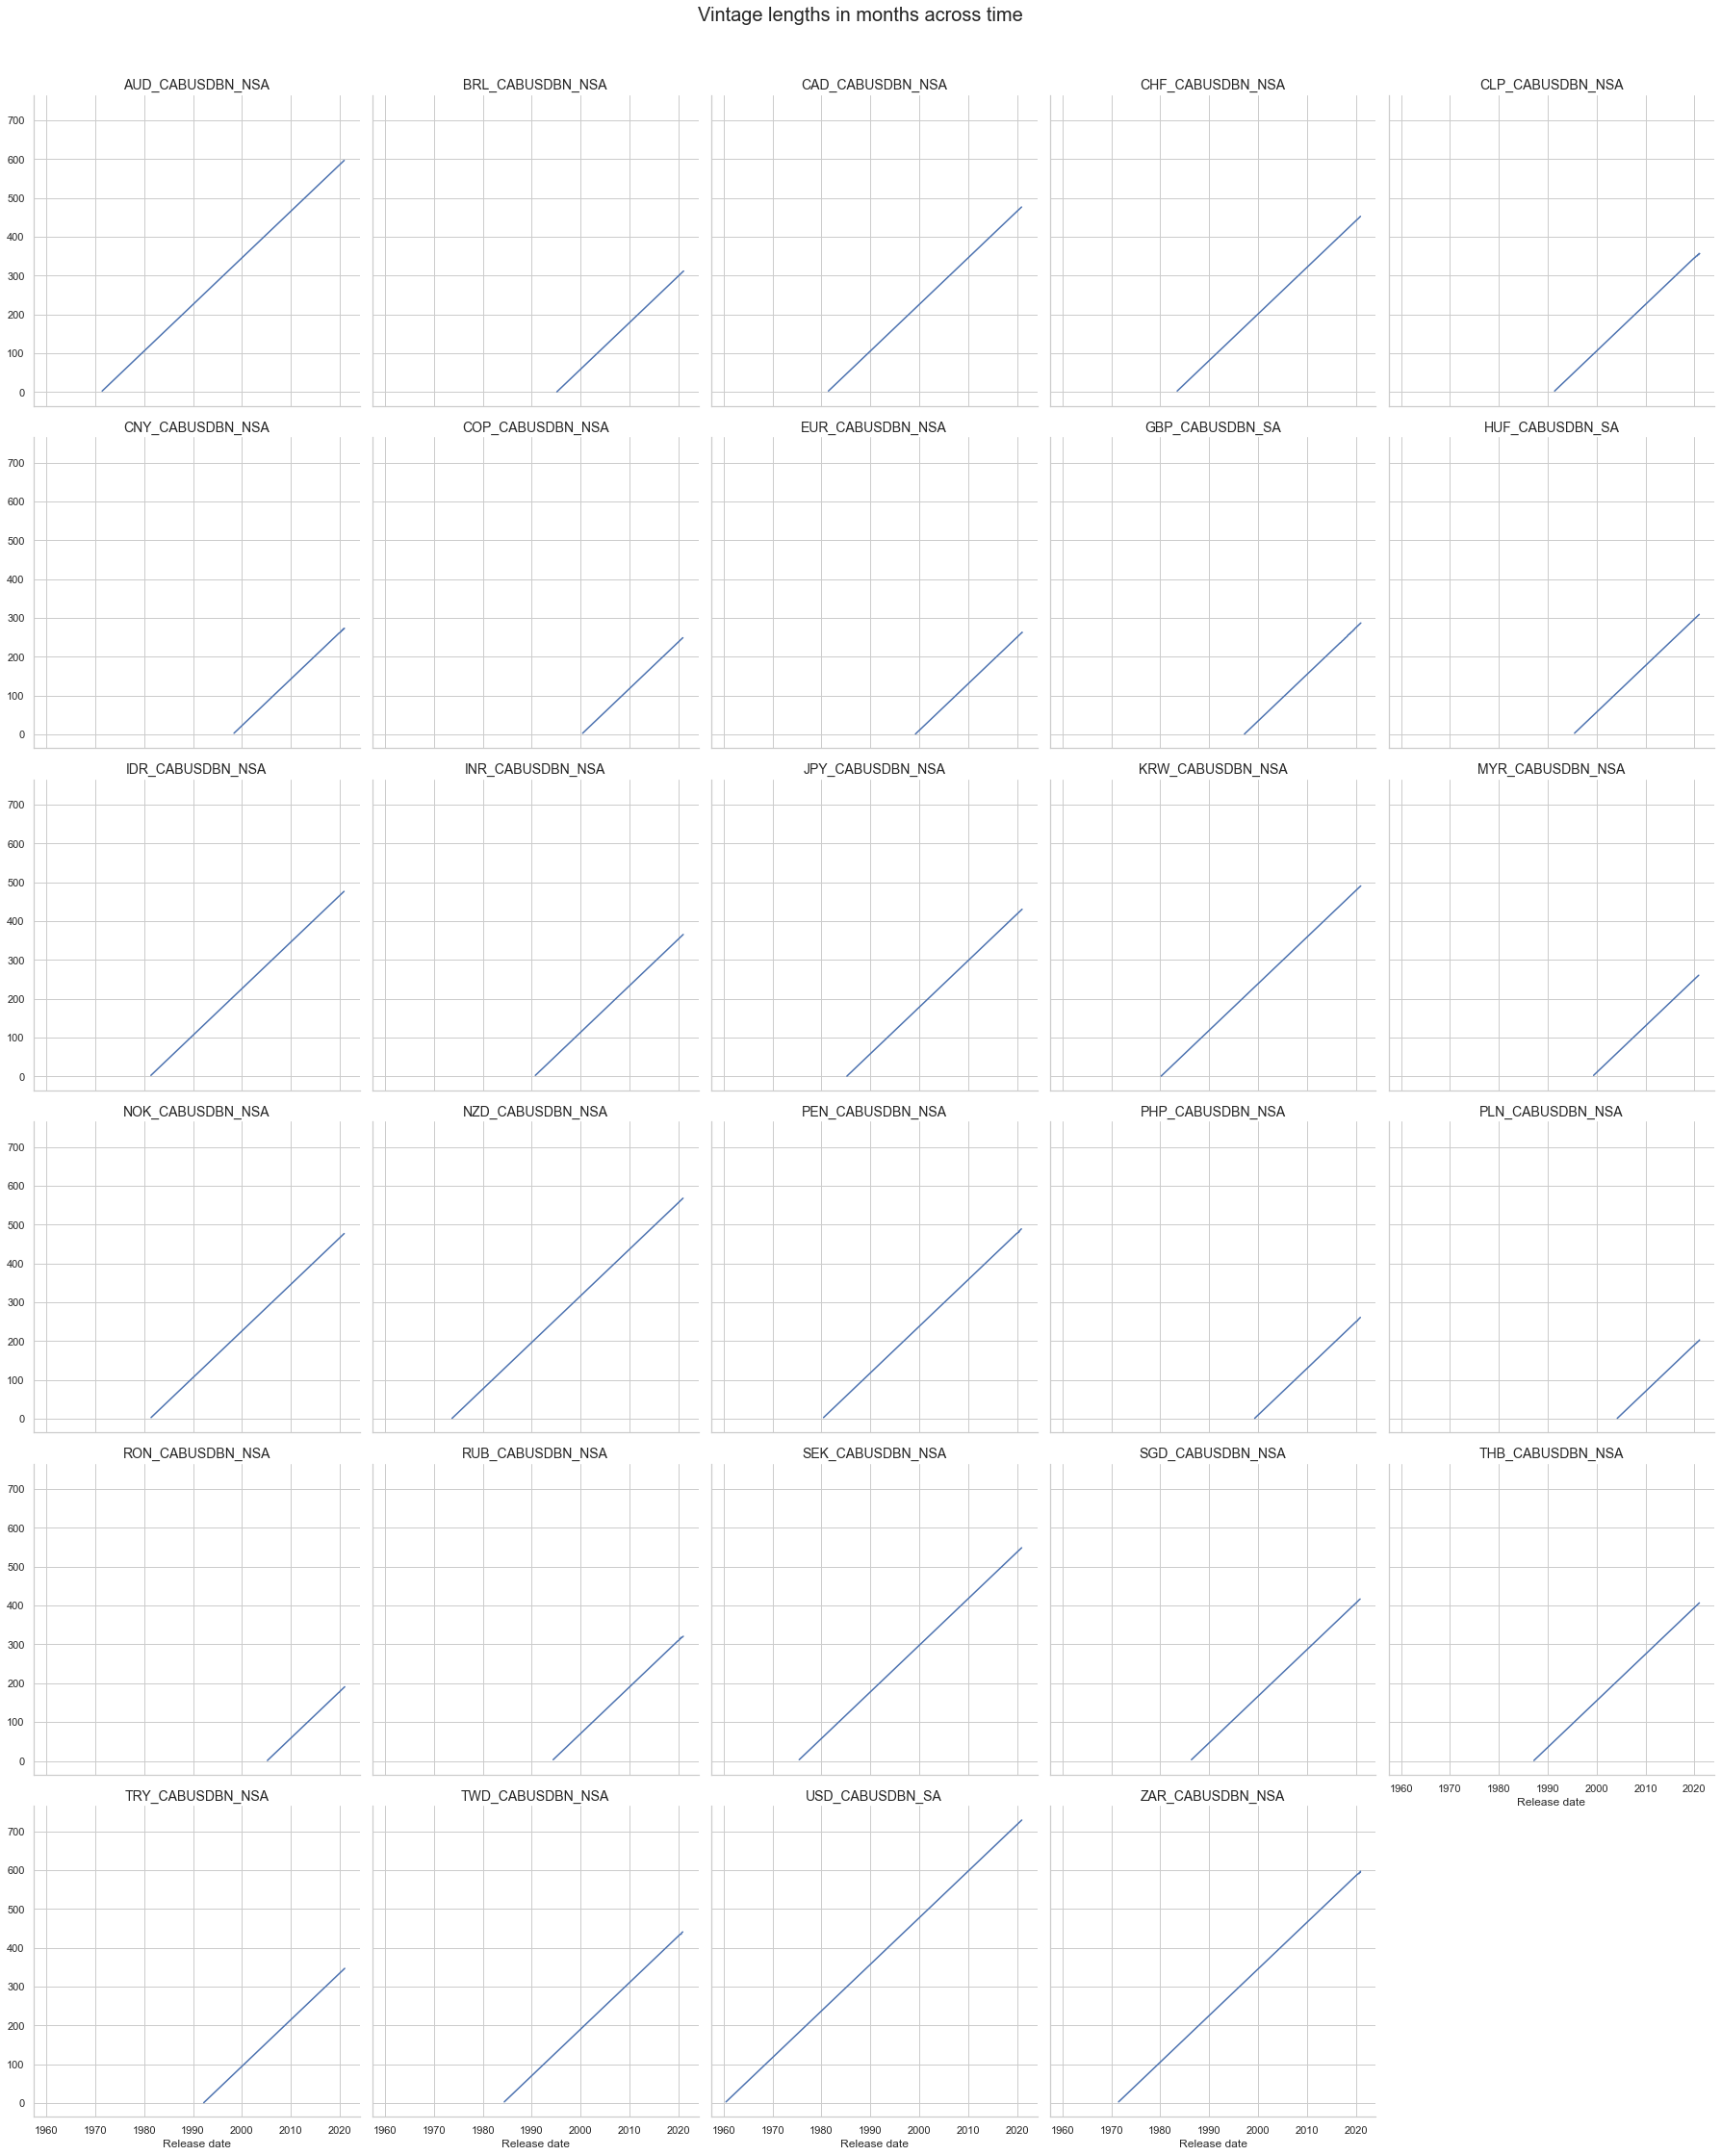

In [45]:
dfm_x = dfm.query('category_code == "CABUSDBN"')
dfm_x = dfm_x.loc[:, ['ticker', 'release_date', 'observation_date']].groupby(['ticker', 'release_date']).agg('count')
dfm_x.reset_index(inplace=True)
f = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='ticker', col_wrap=5)
(f.set_axis_labels("Release date", "")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

In [46]:
dfm_c = dfm.query('category_code == "CABUSDBN"')
tiks = np.sort(dfm_c['ticker'].unique())
for tik in tiks:
    qs.misc.Vintages.vintages_check(dfm_c, tik)

The vintages of AUD_CABUSDBN_NSA display no irregularities.
The vintages of BRL_CABUSDBN_NSA display no irregularities.
The vintages of CAD_CABUSDBN_NSA display no irregularities.
The vintages of CHF_CABUSDBN_NSA display no irregularities.
The vintages of CLP_CABUSDBN_NSA display no irregularities.
The vintages of CNY_CABUSDBN_NSA display no irregularities.
The vintages of COP_CABUSDBN_NSA display no irregularities.
The vintages of EUR_CABUSDBN_NSA display no irregularities.
The vintages of GBP_CABUSDBN_SA display no irregularities.
The vintages of HUF_CABUSDBN_SA display no irregularities.
The vintages of IDR_CABUSDBN_NSA display no irregularities.
The vintages of INR_CABUSDBN_NSA display no irregularities.
The vintages of JPY_CABUSDBN_NSA display no irregularities.
The vintages of KRW_CABUSDBN_NSA display no irregularities.
The vintages of MYR_CABUSDBN_NSA display no irregularities.
The vintages of NOK_CABUSDBN_NSA display no irregularities.
The vintages of NZD_CABUSDBN_NSA display n

### Availability of net FDI balances

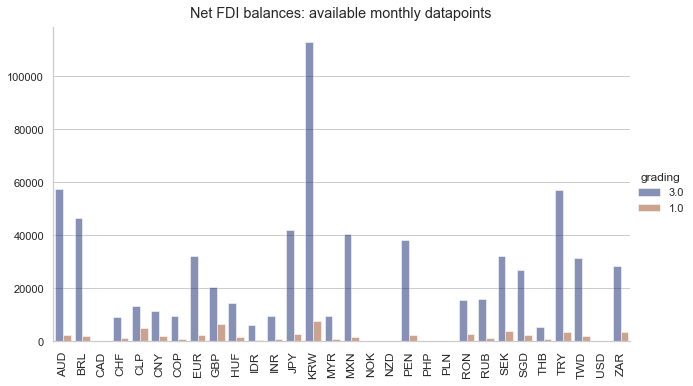

In [47]:
sns.set_theme(style='whitegrid')
g = sns.catplot(data=dfm[dfm['category_code']=='NFDIUSDBN'], kind='count', order=cids, hue='grading',
                x='cross_section', palette='dark', aspect=1.8, alpha=0.5)
g.set_xticklabels(rotation=90, size=12)
g.fig.suptitle('Net FDI balances: available monthly datapoints', y=1.02)
plt.xlabel('')
plt.ylabel('')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

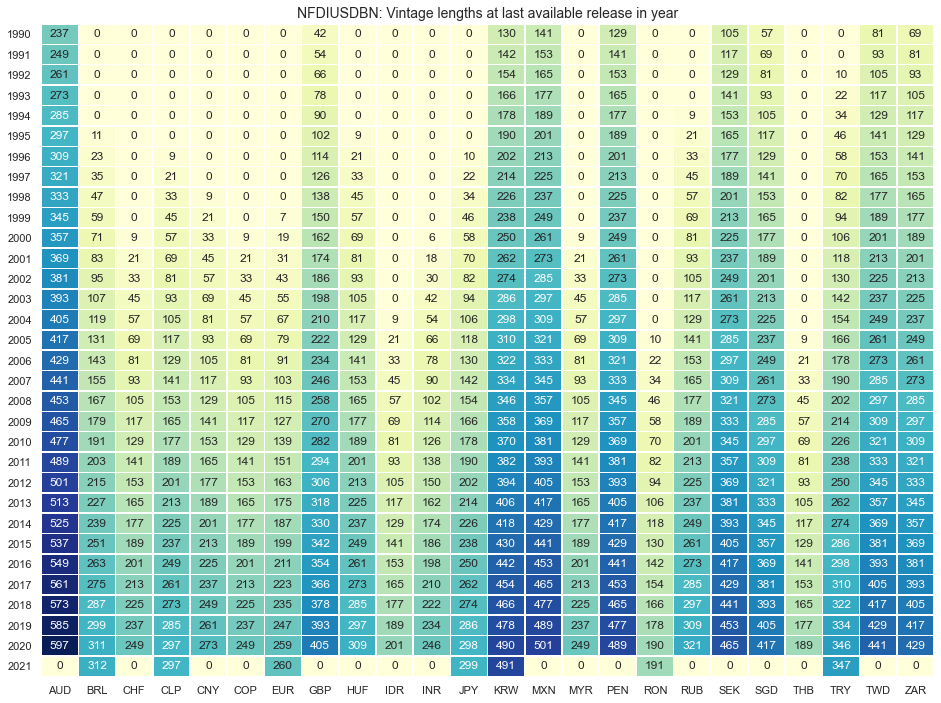

In [48]:
countmap('NFDIUSDBN', 1990, (16, 12))
plt.show

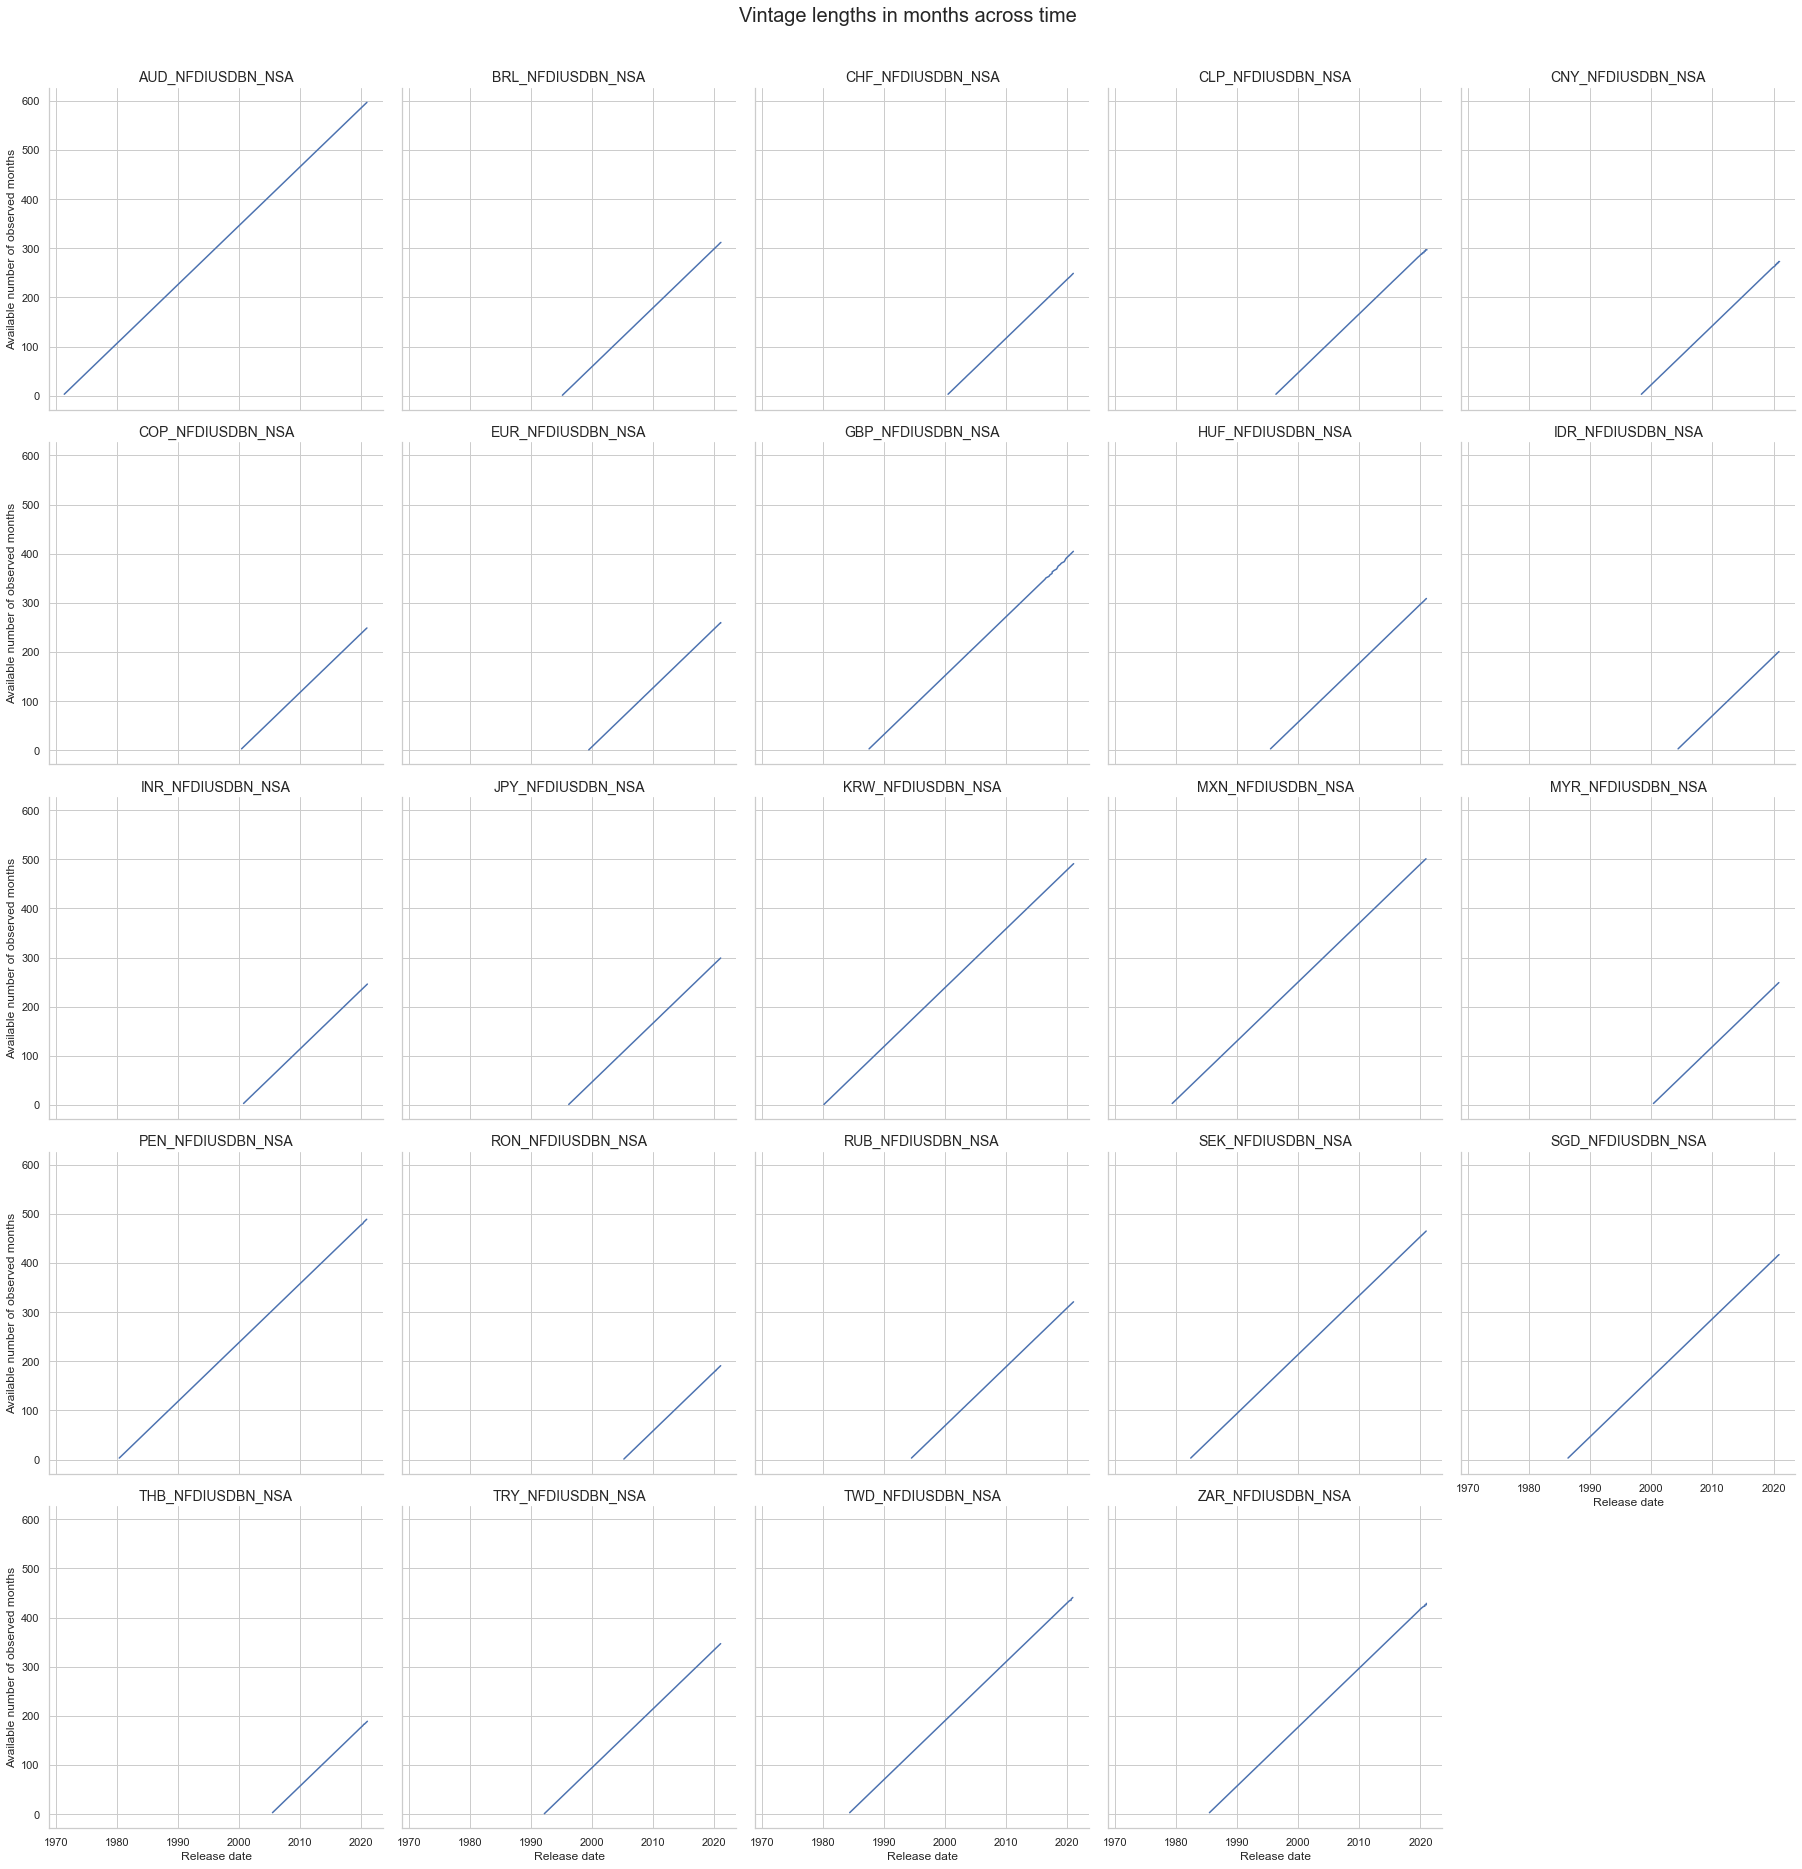

In [49]:
dfm_x = dfm.query('category_code == "NFDIUSDBN"')
dfm_x = dfm_x.loc[:, ['ticker', 'release_date', 'observation_date']].groupby(['ticker', 'release_date']).agg('count')
dfm_x.reset_index(inplace=True)
f = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='ticker', col_wrap=5)
(f.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

In [50]:
dfm_c = dfm.query('category_code == "NFDIUSDBN"')
tiks = np.sort(dfm_c['ticker'].unique())
for tik in tiks:
    qs.misc.Vintages.vintages_check(dfm_c, tik)

The vintages of AUD_NFDIUSDBN_NSA display no irregularities.
The vintages of BRL_NFDIUSDBN_NSA display no irregularities.
The vintages of CHF_NFDIUSDBN_NSA display no irregularities.
The vintages of CLP_NFDIUSDBN_NSA display no irregularities.
The vintages of CNY_NFDIUSDBN_NSA display no irregularities.
The vintages of COP_NFDIUSDBN_NSA display no irregularities.
The vintages of EUR_NFDIUSDBN_NSA display no irregularities.
The vintages of GBP_NFDIUSDBN_NSA display no irregularities.
The vintages of HUF_NFDIUSDBN_NSA display no irregularities.
The vintages of IDR_NFDIUSDBN_NSA display no irregularities.
The vintages of INR_NFDIUSDBN_NSA display no irregularities.
The vintages of JPY_NFDIUSDBN_NSA display no irregularities.
The vintages of KRW_NFDIUSDBN_NSA display no irregularities.
The vintages of MXN_NFDIUSDBN_NSA display no irregularities.
The vintages of MYR_NFDIUSDBN_NSA display no irregularities.
The vintages of PEN_NFDIUSDBN_NSA display no irregularities.
The vintages of RON_NFDI

## Revisions

In [12]:
def revlines(df, pots, ncols=4, size = (16, 16)):
    
    xids = np.sort(df['cross_section'].unique())
    
    sns.set_style('whitegrid')
    colors = sns.color_palette("Blues", len(pots))
    fig, axes = plt.subplots(nrows=math.ceil(len(xids)/ncols), ncols=ncols, sharex=True, figsize=size)

    for i in range(len(xids)):
        cid = xids[i]
        dfc = df.query('cross_section == @cid')
        releases = dfc['release_date'].unique()
        selected_releases = [None] * len(pots)
        for p in range(len(pots)):  # get releases nearest and before chosen ones
            release = releases[(releases <= pd.to_datetime(pots[p]))].max()
            selected_releases[p] = release
        dfcx = dfc[dfc['release_date'].isin(selected_releases)]
        axe = axes[math.floor(i / ncols), (i % ncols)]
        sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                     hue="release_date", palette=colors, ax=axe)
        axe.set(title=cid, ylabel="", xlabel="")

    plt.show()

### Revisions of merchandise trade balances

<function matplotlib.pyplot.show(*args, **kw)>

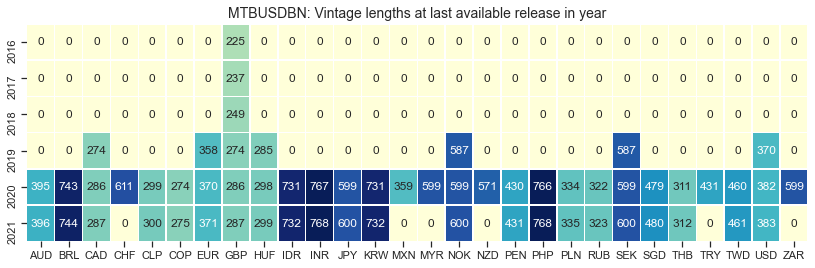

In [68]:
countmap('MTBUSDBN', 1990, (14, 4), trueVin=True)
plt.show

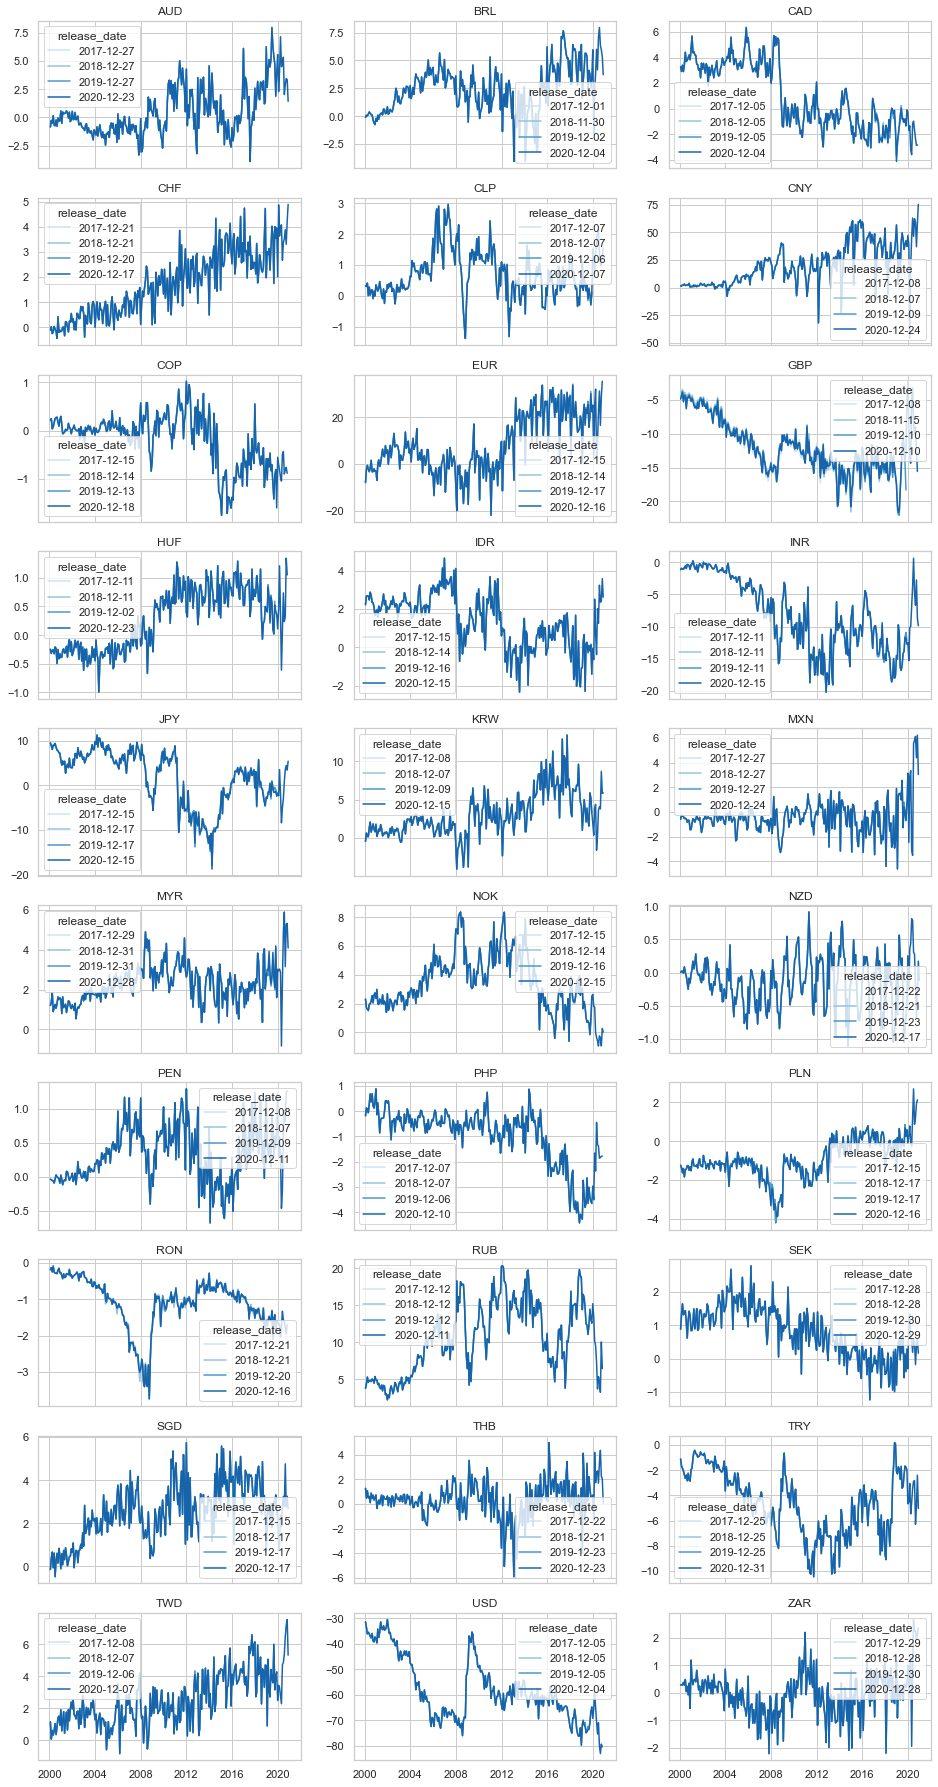

In [15]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'MTBUSDBN'
dfm_x = dfm[filt1 & filt2]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 32))

### Revisions of current account balances

<function matplotlib.pyplot.show(*args, **kw)>

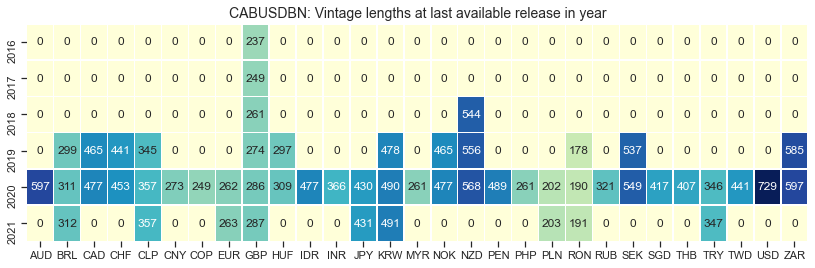

In [69]:
countmap('CABUSDBN', 1990, (14, 4), trueVin=True)
plt.show

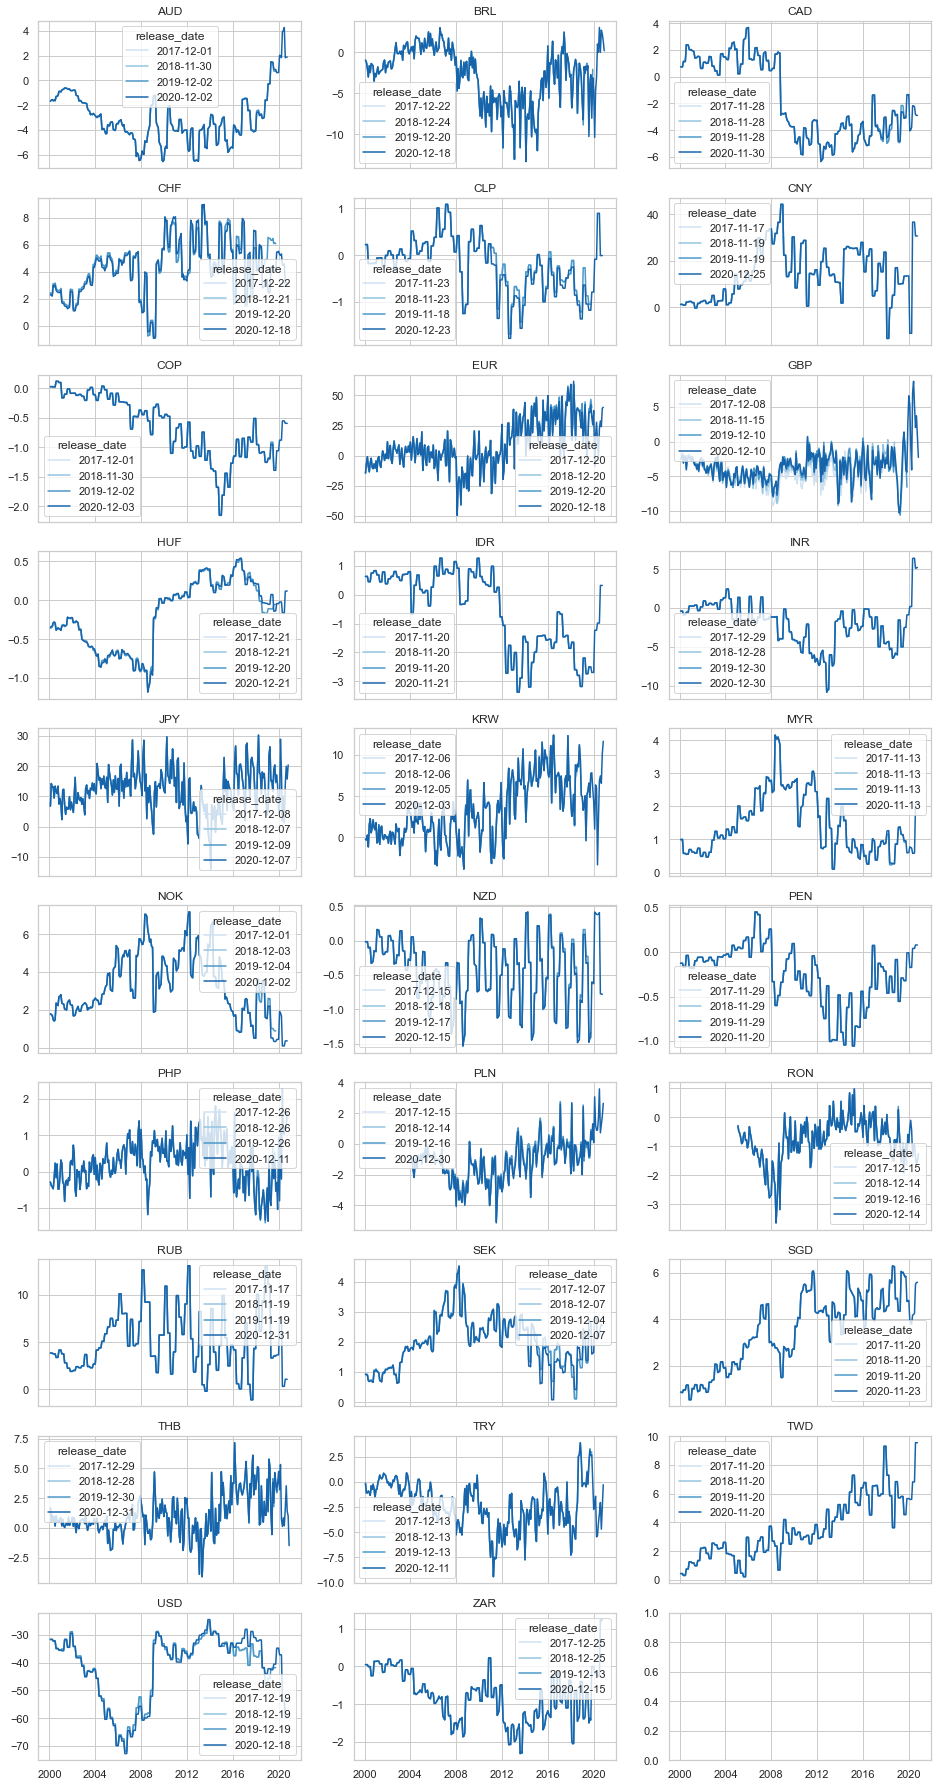

In [57]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'CABUSDBN'
dfm_x = dfm[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=3, size = (16, 32))

### Revisions of net FDI balances

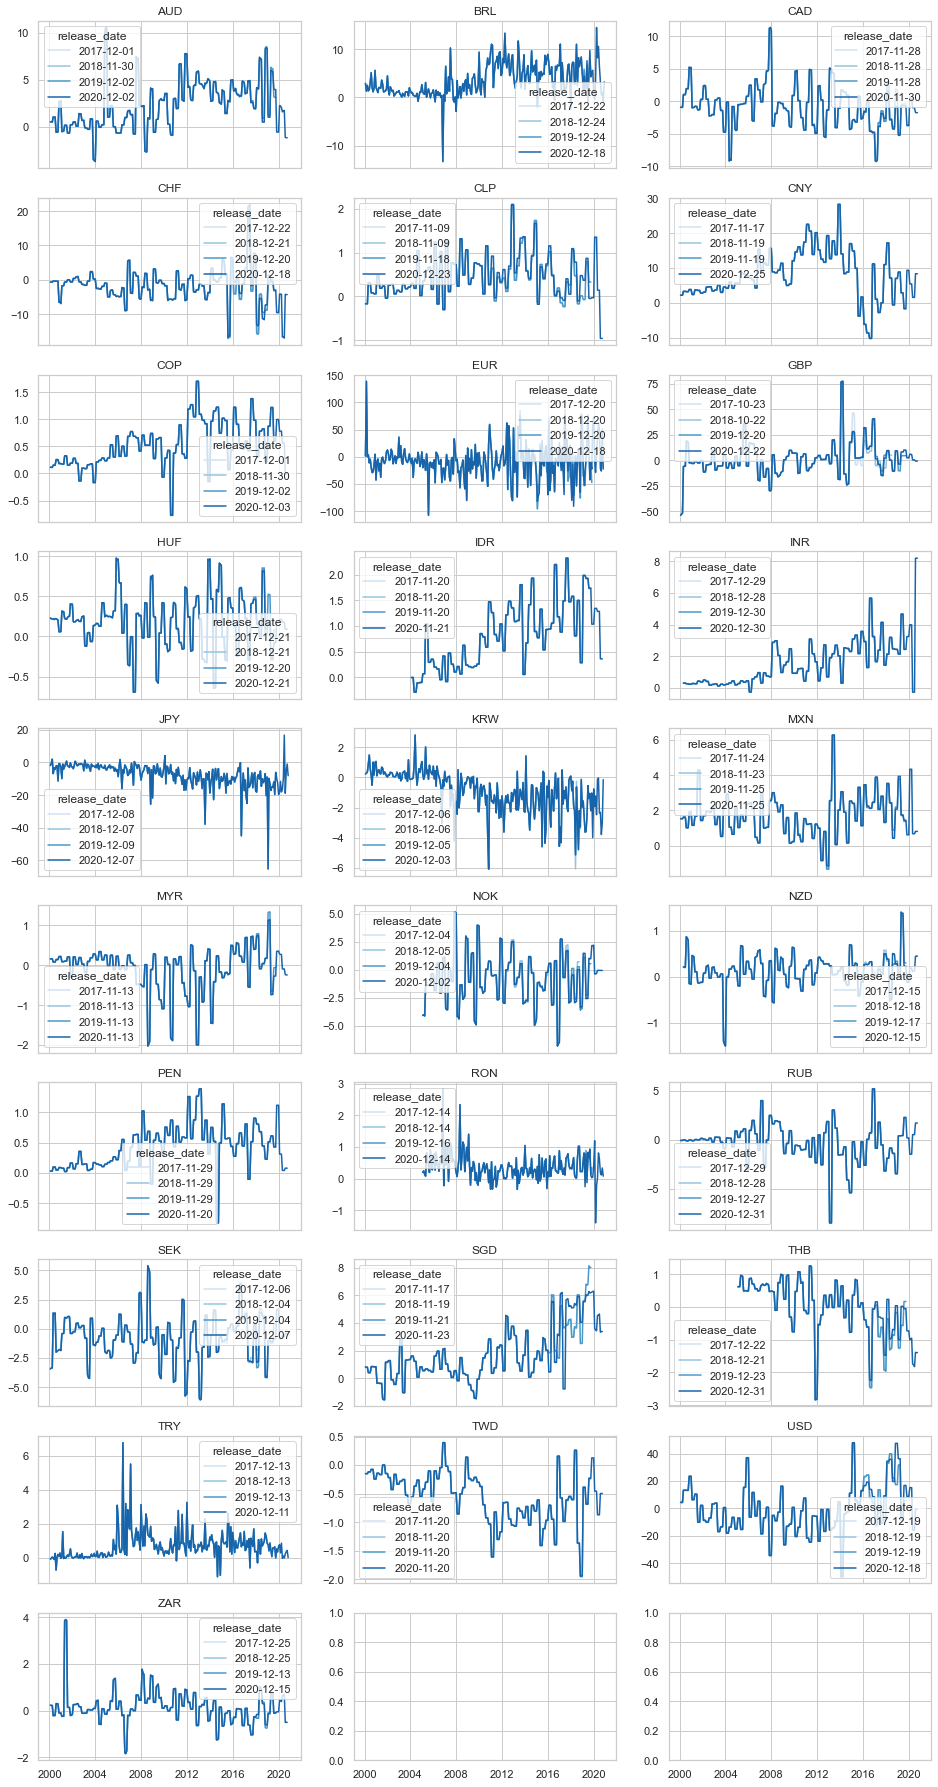

In [28]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'NFDIUSDBN'
dfm_x = dfm[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=3, size = (16, 32))

## Glance at latest vintages

In [58]:
indices = []
for tick in dfm.ticker.unique():  # extract dataframe with last release_dates for each ticker only
    dfmx = dfm[dfm['ticker'] == tick]
    dfmxx = dfmx[dfmx['release_date'] == dfmx['release_date'].max()]
    indices = indices + dfmxx.index.tolist()
dfm_g = dfm.iloc[indices, :]

In [61]:
def ranges_balances(xids):
    dfm_gx = dfm_g.query('cross_section in @xids')  # extract only group cross sections
    f, ax = plt.subplots()  # set figure, single axis
    f.set_size_inches(8, len(xids))
    sns.set(style="whitegrid", palette = 'Blues')  
    sns.despine(bottom=True, left=True)
    sns.stripplot(data=dfm_gx, # plot one observation strip per cross section and category code
                  x="value", y="cross_section", order=xids,
                  hue="category_code", hue_order=cats,
                  dodge=True, alpha=.2, zorder=1)
    sns.pointplot(data=dfm_gx,  # plot one mean marker
                  x="value",  y="cross_section", 
                  hue="category_code", hue_order=cats,
                  dodge=.4, join=False, palette='Blues',
                  markers="v", scale=1.5, alpha=1, ci='sd')
    f.suptitle('Averages and ranges of latest vintage of external balances', y = 0.97, fontsize=14)
    ax.set(xlabel='USD bn', ylabel='')
    handles, labels = ax.get_legend_handles_labels()  # refers to labels of strip- and pointplots
    cat_length = len(dfm_gx['category_code'].unique())  # number of scategories displayed
    ax.legend(handles[cat_length:], labels[cat_length:], title="categories",  # category legend box
              handletextpad=0, columnspacing=1,
              loc="lower right", ncol=1, frameon=True)
    plt.show()

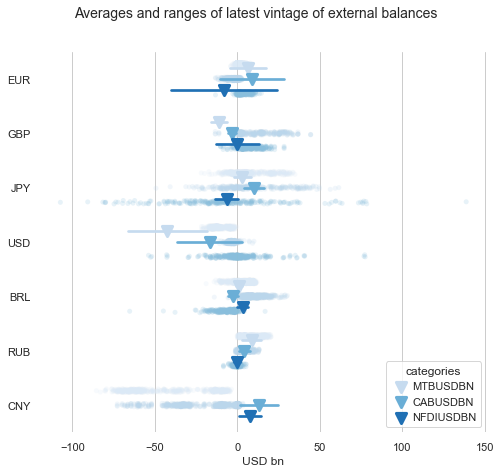

In [62]:
cids_large = ['BRL', 'CNY', 'EUR', 'GBP', 'JPY', 'RUB', 'USD']
ranges_balances(cids_large)

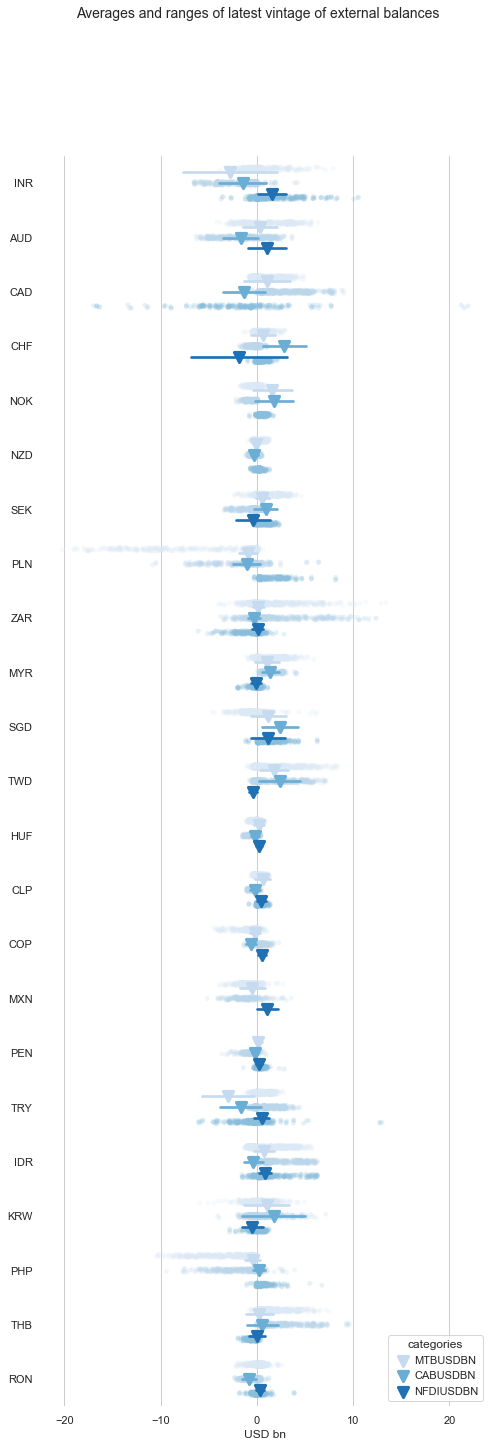

In [63]:
cids_small = [cid for cid in cids if cid not in cids_large]
ranges_balances(cids_small)

# Plausibility of relations

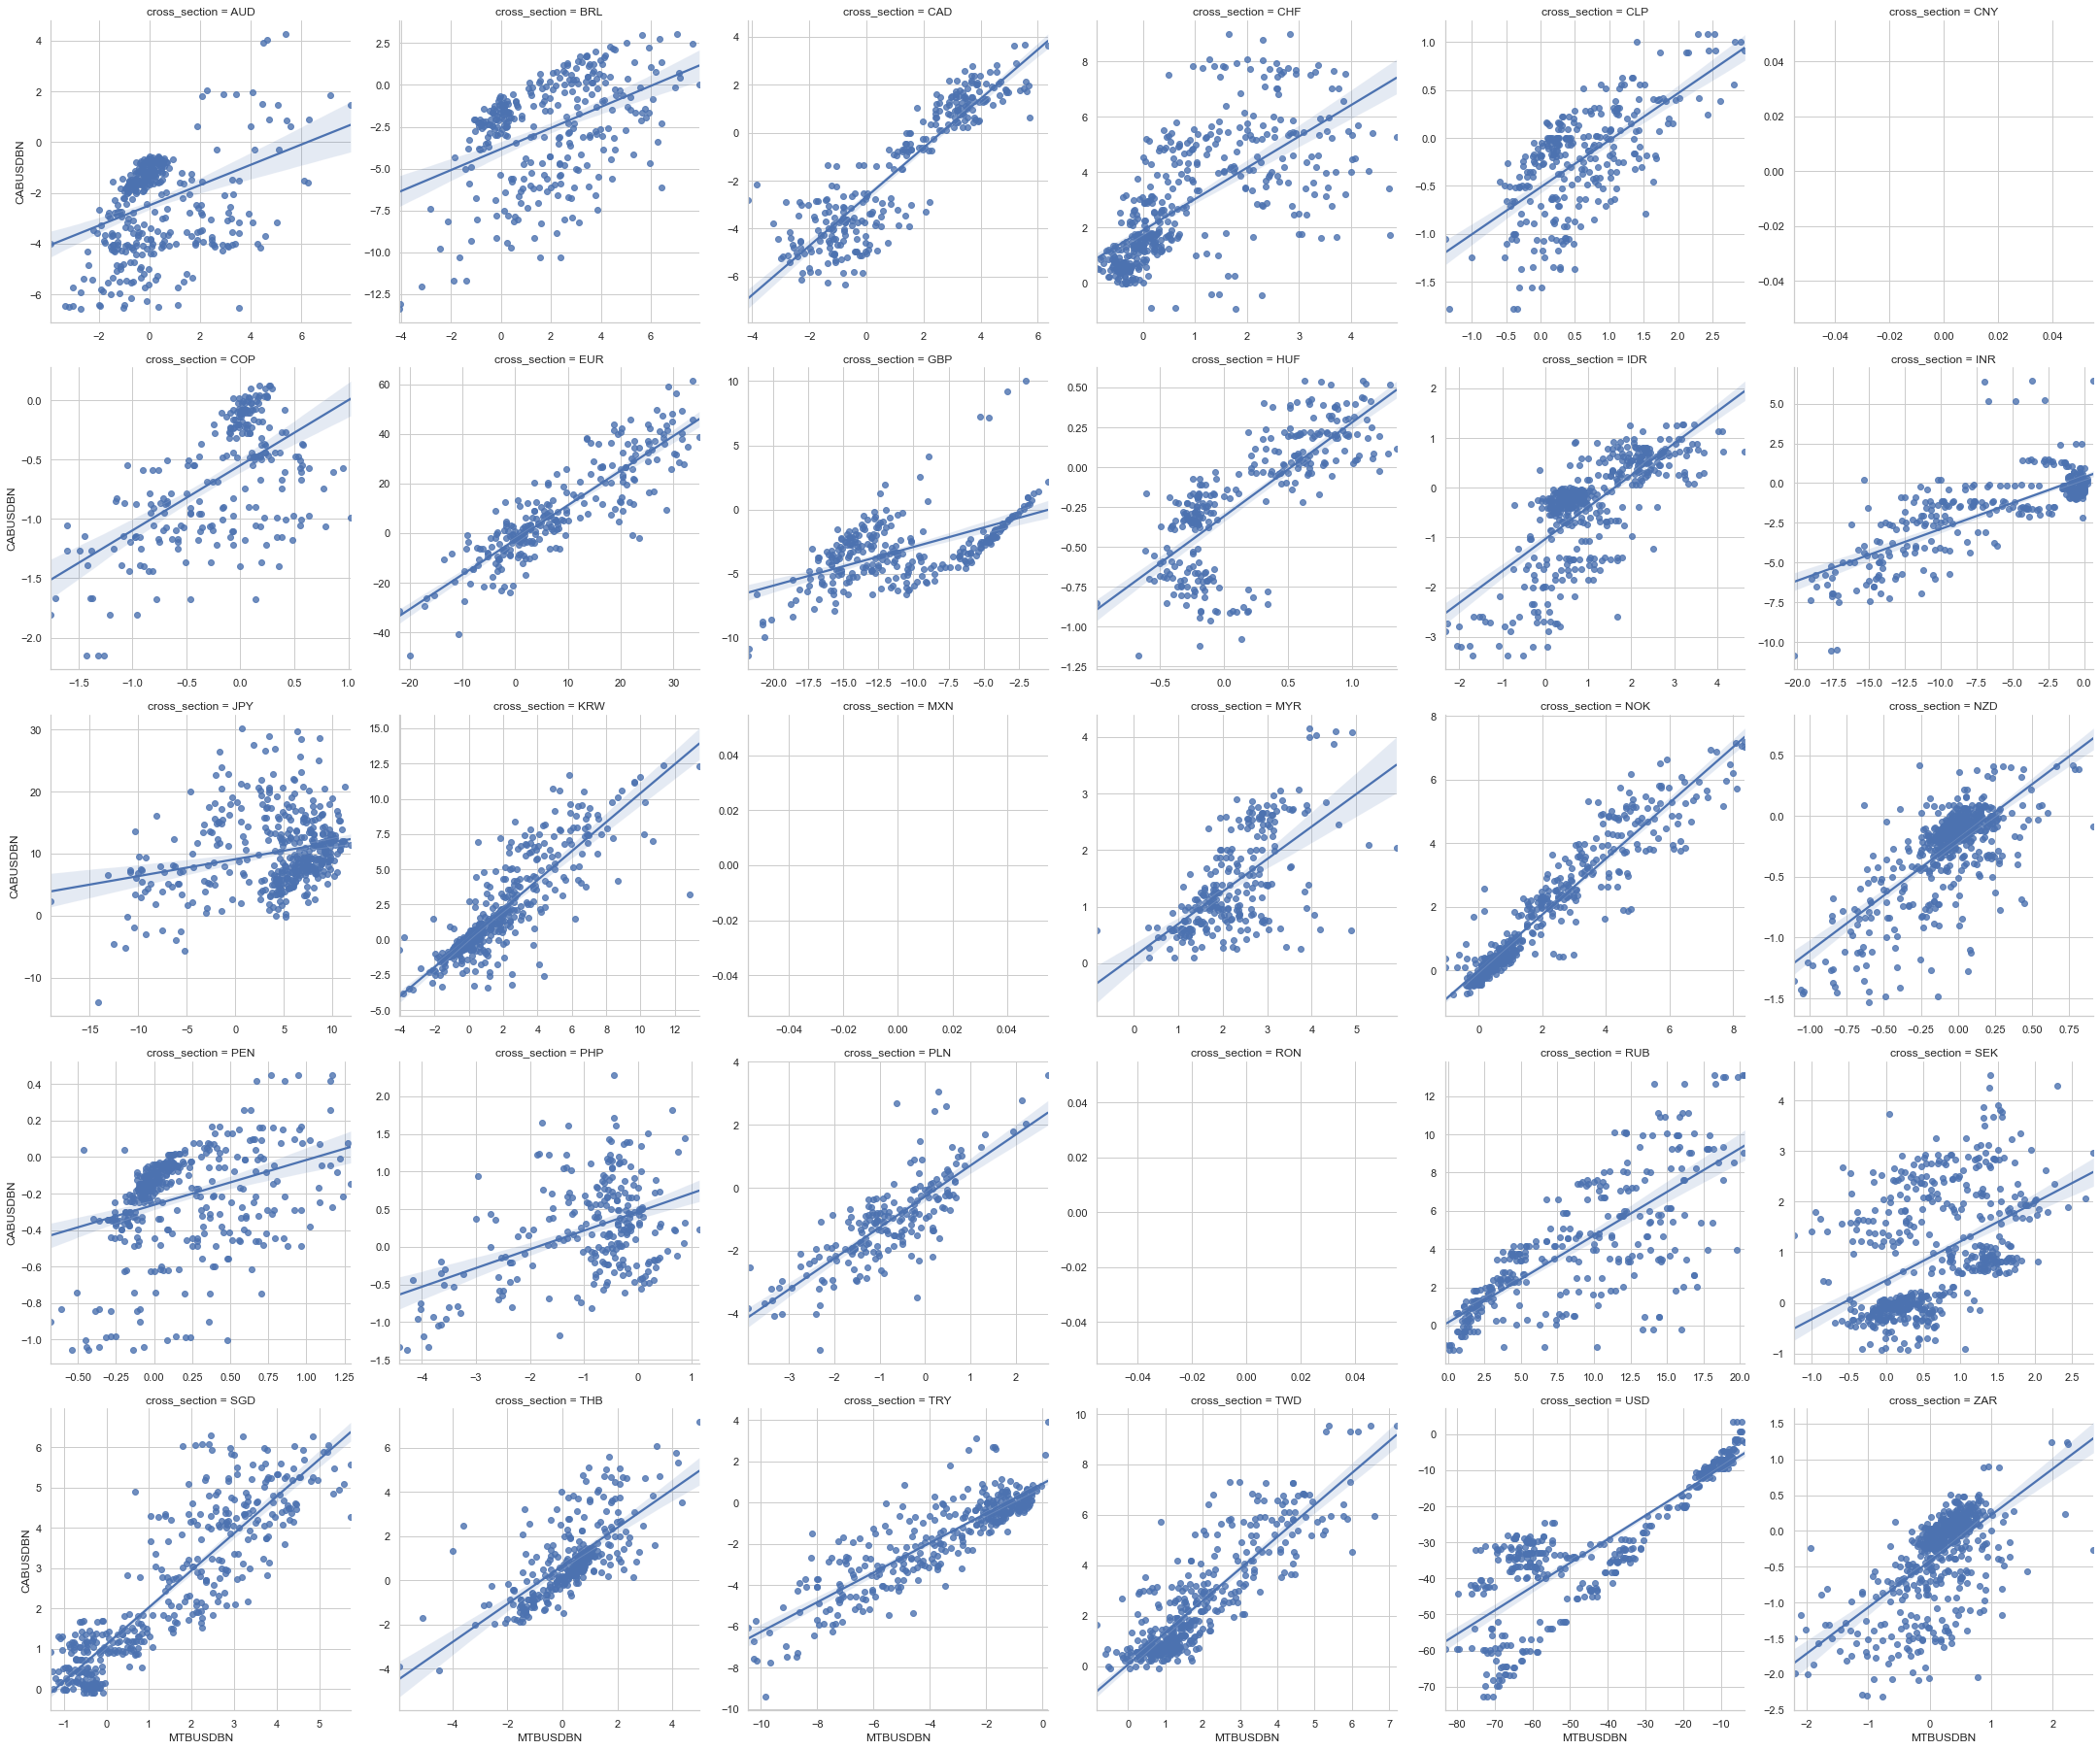

In [64]:
dfm_w = dfm_g.set_index(['cross_section', 'category_code', 'observation_date'])['value']
dfm_w = dfm_w.unstack(1).reset_index()
dfm_w.tail()

sns.set_theme(style="whitegrid")
sns.lmplot(data=dfm_w, x="MTBUSDBN", y="CABUSDBN", palette='Blues',
           col="cross_section", col_wrap=6, fit_reg=True,
           sharex=False, sharey=False)
plt.show()

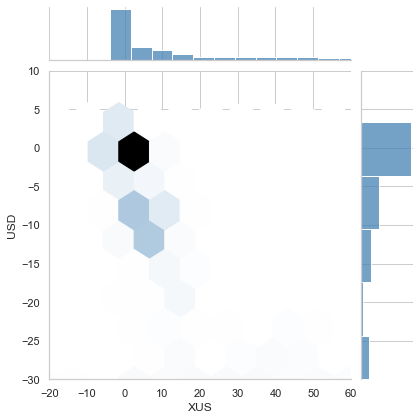

In [65]:
dfm_gx = dfm_g.query('category_code == "CABUSDBN"')[['cross_section', 'observation_date', 'value']]
dfm_gw = dfm_gx.pivot(index='observation_date', columns='cross_section', values='value')
cxu = [cid for cid in dfm_gw.columns if not cid=='USD']
dfm_gw['XUS'] = dfm_gw[cxu].agg("sum", axis=1)  # sum of all non-USD balances

# Hexbin plot with marginal distributions of two series
sns.jointplot(data=dfm_gw, kind="hex",
              x='XUS', y='USD', xlim=(-20, 60), ylim=(-30, 10), 
              color="steelblue")
plt.show()


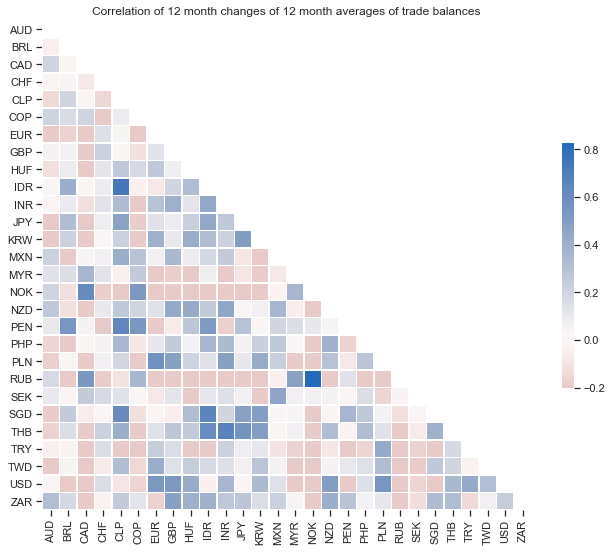

In [66]:
dfm_gx = dfm_g.query('category_code == "MTBUSDBN"')[['cross_section', 'observation_date', 'value']]
dfm_gw = dfm_gx.pivot(index='observation_date', columns='cross_section', values='value').rolling(12).mean().diff(12)

sns.set(style="ticks")  
corr = dfm_gw.corr()  # compute correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
f, ax = plt.subplots(figsize=(11, 9))  # set up figure

sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set(xlabel='', ylabel='', title = 'Correlation of 12 month changes of 12 month averages of trade balances', aspect = 1)
plt.show()